# <font style="color:blue">Project 2: Kaggle Competition - Classification</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Data Loader</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Configuration</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Evaluation Metric</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Train and Validation</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Model</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>Utils</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>Experiment</h3></td><td><h3>5</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>TensorBoard Log</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>9</h3></td> <td><h3>Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>


## <font style="color:green">1. Data Loader [10 Points]</font>

In this section, you have to write a class or methods, which will be used to get training and validation data loader.

You need to write a custom dataset class to load data.

**Note; There is   no separate validation data. , You will thus have to create your own validation set, by dividing the train data into train and validation data. Usually, we do 80:20 ratio for train and validation, respectively.**


For example:

```python
class KenyanFood13Dataset(Dataset):
    """
    
    """
    
    def __init__(self, *args):
    ....
    ...
    
    def __getitem__(self, idx):
    ...
    ...
    
    
```

```
def get_data(args1, *agrs):
    ....
    ....
    return train_loader, test_loader
```

In [1]:
%matplotlib inline

In [144]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.transforms import functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
import time

from typing import Iterable
from dataclasses import dataclass

from PIL import Image

In [143]:
class KenyanFood13Dataset(Dataset):
    """
    This custom dataset class takes root directory and train flag, 
    and returns dataset training dataset if train flag is true 
    else it returns validation dataset.
    """
    
    def __init__(self, data_root, train=True, image_shape=None, transform=None):
        
        """
        init method of the class.
        
         Parameters:
         
         data_root (string): path of root directory.
         
         train (boolean): True for training dataset and False for test dataset.
         
         image_shape (int or tuple or list): [optional] int or tuple or list. Defaut is None. 
                                             If it is not None image will resize to the given shape.
                                 
         transform (method): method that will take PIL image and transform it.
         
        """
        
        # get label to species mapping
        label_csv_path = os.path.join(data_root, 'train.csv')
        self.data_df = pd.read_csv(label_csv_path, delimiter=' *, *', engine='python')
        self.classes = self.data_df.iloc[:, 1].unique()
        self.num_classes = len(self.classes)
        self.image_ids = self.data_df.iloc[:, 0]

        self.class_given_label = {image_id : image_class for image_id, image_class in enumerate(self.classes)}
        self.label_given_class = {image_class : image_id for image_id, image_class in enumerate(self.classes)}
        
        # set image_resize attribute
        if image_shape is not None:
            if isinstance(image_shape, int):
                self.image_shape = (image_shape, image_shape)
            
            elif isinstance(image_shape, tuple) or isinstance(image_shape, list):
                assert len(image_shape) == 1 or len(image_shape) == 2, 'Invalid image_shape tuple size'
                if len(image_shape) == 1:
                    self.image_shape = (image_shape[0], image_shape[0])
                else:
                    self.image_shape = image_shape
            else:
                raise NotImplementedError 
                
        else:
            self.image_shape = image_shape
            
        # set transform attribute
        self.transform = transform

        # initialize the data dictionary
        self.data_dict = {
            'image_path': [],
            'label': []
        }
        img_dir = os.path.join(data_root, 'images', 'images')

        # print("self.data_df", type(self.data_df))
        for data in self.data_df.iterrows():
            image_id = str(data[1]['id']) + '.jpg'
            image_path = os.path.join(img_dir, image_id)
            image_class = data[1]['class']
            label = self.label_given_class[image_class]
            self.data_dict['image_path'].append(image_path)
            self.data_dict['label'].append(label)

    
    def __len__(self):
        """
        return length of the dataset
        """
        return len(self.data_dict['label'])
    
    
    def __getitem__(self, idx):
        """
        For given index, return images with resize and preprocessing.
        """
        
        image = Image.open(self.data_dict['image_path'][idx]).convert("RGB")
        
        if self.image_shape is not None:
            image = F.resize(image, self.image_shape)
            
        if self.transform is not None:
            image = self.transform(image)
            
        target = self.data_dict['label'][idx]
        
        return image, target            
                
        
    def class_name(self, label):
        """
        class label to common name mapping
        """
        return self.class_given_label[label]

Length of the dataset: 6536
Label: 4, class name: sukumawiki


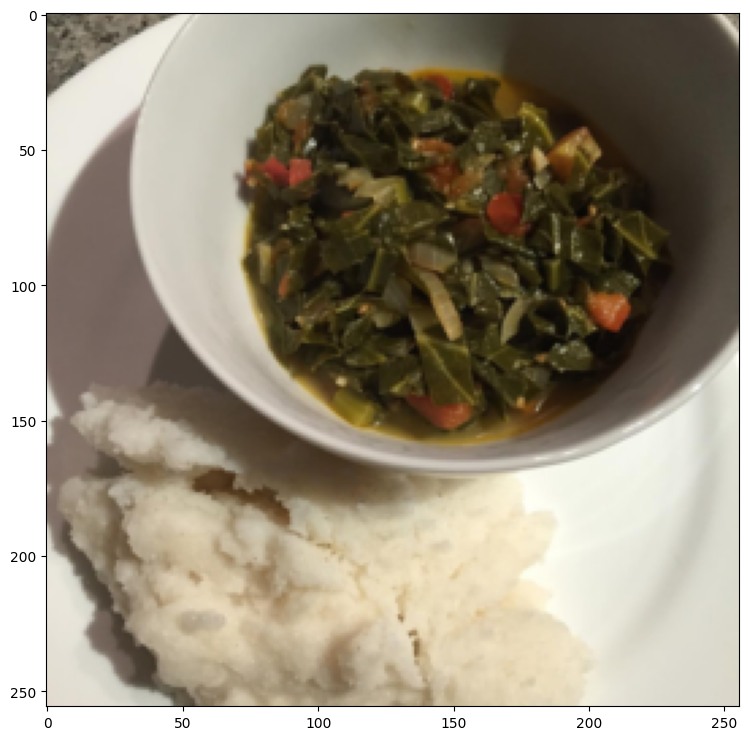

In [127]:
# data root directory
# data_root = '../resource/lib/publicdata/images/10-monkey-species'
data_root = '../../../data/Week7_project2_classification/KenyanFood13Dataset'

dataset =  KenyanFood13Dataset(data_root, train=True, image_shape=256)

print('Length of the dataset: {}'.format(len(dataset)))

img, trgt = dataset[300]

print('Label: {}, class name: {}'.format(trgt, dataset.class_name(trgt)))
plt.imshow(img)
plt.show()


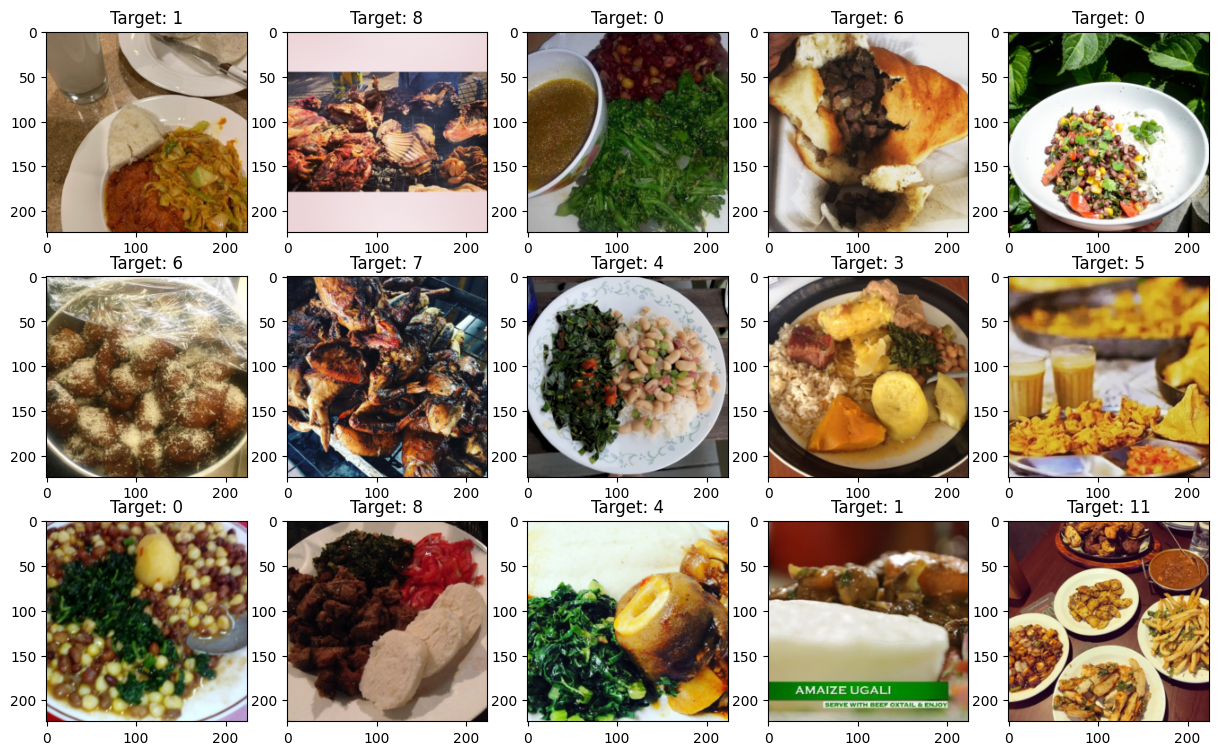

In [139]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
    ])

dataset =  KenyanFood13Dataset(data_root, train=False, image_shape=None, transform=preprocess)


train_size = int(0.8 * len(dataset)) # 80% for training
validation_size = len(dataset) - train_size # 20% for validation

train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])



# dataloader with dataset
validation_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=15,
        shuffle=True,
        num_workers=2
    )


# Plot few images
plt.rcParams["figure.figsize"] = (15, 9)
plt.figure
for images, labels in validation_loader:
    for i in range(len(labels)):
        plt.subplot(3, 5, i+1)
        img = F.to_pil_image(images[i])
        plt.imshow(img)
        plt.gca().set_title('Target: {0}'.format(labels[i]))
    plt.show()
    break

## <font style="color:green">2. Configuration [5 Points]</font>

**Define your configuration here.**

For example:


```python
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 10 
    epochs_count: int = 50  
    init_learning_rate: float = 0.1  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = "/kaggle/input/opencv-pytorch-classification-project-2/" 
    num_workers: int = 2  
    device: str = 'cuda'  
    
```

In [146]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 42  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

In [147]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 5 #32  # amount of data to pass through the network at each forward-backward iteration
    epochs_count: int = 20  # number of times the whole dataset will be passed through the network
    learning_rate: float = 0.001  # determines the speed of network's weights update
    log_interval: int = 100  # how many batches to wait between logging training status
    test_interval: int = 1  # how many epochs to wait before another test. Set to 1 to get val loss at each epoch
    # data_root: str = "data"  # folder to save MNIST data (default: data/mnist-data)
    data_root: str = '../../../data/Week7_project2_classification/KenyanFood13Dataset'
    num_workers: int = 10  # number of concurrent processes used to prepare data
    device: str = 'cuda'  # device to use for training.

## <font style="color:green">3. Evaluation Metric [10 Points]</font>

**Define methods or classes that will be used in model evaluation. For example, accuracy, f1-score etc.**

In [ ]:
class Visualizer:
    def __init__(self):
        self._epochs = []
        self._metrics = defaultdict(list)

    def plot(self):
        for key, value in self._metrics.items():
            self._plot_metric(key, value)

    @abstractmethod
    def _plot_metric(self, metric_name, metric_values):
        # do the visualization
        pass

    def update_metrics(self, name, value, epoch):
        self._metrics[name].append(value)
        self._epochs.append(epoch)

## <font style="color:green">4. Train and Validation [5 Points]</font>


**Write the methods or classes to be used for training and validation.**

## <font style="color:green">5. Model [5 Points]</font>

**Define your model in this section.**

**You are allowed to use any pre-trained model.**

## <font style="color:green">6. Utils [5 Points]</font>

**Define those methods or classes, which have  not been covered in the above sections.**

## <font style="color:green">7. Experiment [5 Points]</font>

**Choose your optimizer and LR-scheduler and use the above methods and classes to train your model.**

## <font style="color:green">8. TensorBoard Log [5 Points]</font>

**Share your TensorBoard scalars logs here You can also share (not mandatory) your GitHub link, if you have pushed this project in GitHub.**


<font style="color:red">Note:</font> In light of the recent shutdown of tensorboard.dev, we have updated the submission requirements for your project. Instead of sharing a tensorboard.dev link, you are now required to upload your generated TensorBoard event files directly onto the lab. As an alternative, you may also include a screenshot of your TensorBoard output within your Jupyter notebook. This adjustment ensures that your data visualization and model training efforts are thoroughly documented and accessible for evaluation.

## <font style="color:green">9. Kaggle Profile Link [50 Points]</font>

**Share your Kaggle profile link  with us here to score , points in  the competition.**

**For full points, you need a minimum accuracy of `75%` on the test data. If accuracy is less than `70%`, you gain  no points for this section.**


**Submit `submission.csv` (prediction for images in `test.csv`), in the `Submit Predictions` tab in Kaggle, to get evaluated for  this section.**